In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import torch.nn as nn
import numpy as np

class SSLayer(nn.Module):
    def __init__(self, n_x, n_u, n_y):
        super(SSLayer, self).__init__()
        self.n_x, self.n_u, self.n_y = n_x, n_u, n_y
        self.init_parameters()
    
    def init_parameters(self):
        # Initialize parameters
        self.mu = nn.Parameter(torch.randn(self.n_x))  # Shape: (n_x,) diagonal of A
        self.theta = nn.Parameter(torch.randn(self.n_x))  # Shape: (n_x,)
        self.B_norm = nn.Parameter(torch.randn(self.n_x, self.n_u))  # Shape: (n_x, n_u)
        self.C = nn.Parameter(torch.randn(self.n_y, self.n_x))  # Shape: (n_y, n_x)
        self.D = nn.Parameter(torch.randn(self.n_y, self.n_u))  # Shape: (n_y, n_u)
        self.F = nn.Parameter(torch.eye(self.n_y, self.n_u))  # Shape: (n_y, n_u)
        
        # Normalize B
        self.normalize_B()
    
    def normalize_B(self):
        lambdas = torch.exp(-torch.exp(self.mu) + 1j * self.theta) #EV of A
        gamma = torch.sqrt(1 - torch.abs(lambdas)**2).view(-1, 1)  # Shape: (n_x, 1)
        self.B = nn.Parameter(gamma * self.B_norm)  # Shape: (n_x, n_u)
        print(self.B.shape)
    
    def forward(self, u):
        # Ensure the input shape is (batch_size, time_steps, n_u)
        batch_size = u.size(0)
        time_steps = u.size(1)

        # Initialize hidden state (in complex)
        x = torch.zeros(batch_size, self.n_x, dtype=torch.complex64, device=u.device).transpose(0,1)   # Shape: (batch_size, n_x)

        # Initialize output list
        outputs = []

        # Matrix A computed from parameters (in complex)
        A = torch.diag_embed(torch.exp(-torch.exp(self.mu) + 1j * self.theta))  # Shape: (n_x, n_x)
        for t in range(time_steps):  # Iterate over time steps
            # Extract current input (convert to complex)
            u_t = u[:, t, :].to(torch.complex64).transpose(0,1)  # Shape: (batch_size, n_u)
            
            """
            # Debugging shapes before operations
            print(f"Step {t}")
            print(f"A shape: {A.shape}")  # (4, 4)
            print(f"x shape: {x.shape}")  # (batch_size, 4)
            print(f"self.B shape: {self.B.shape}")  # (4, 5)
            print(f"u_t shape: {u_t.shape}")  # (batch_size, 5)
"""
            # Compute next state
            x_next = A @ x + self.B.to(torch.complex64) @ u_t  # Ensure this aligns correctly
            eta = self.C.to(torch.complex64) @ x_next + self.D.to(torch.complex64) @ u_t  # Ensure this aligns correctly
            output = torch.tanh(eta) + self.F.to(torch.complex64) @ u_t  # Ensure this aligns correctly

            outputs.append(output)

            # Update state for the next time step
            x = x_next
        
        return torch.stack(outputs, dim=1)  # Shape: (batch_size, time_steps, n_y)





class SSM(nn.Module):
    def __init__(self, n_layers, n_x, n_u, n_y):
        super(SSM, self).__init__()
        
        self.layers = nn.ModuleList([SSLayer(n_x, n_u, n_y) for _ in range(n_layers)])

    def forward(self, u):
        # Pass the input through each layer sequentially
        for layer in self.layers:
            u = layer(u)  # Each layer processes the output of the previous one
        return u  # Final output after all layers


# Instantiate the model with example dimensions
n_layers, n_x, n_u, n_y = 1, 4, 6, 2
model = SSM(n_layers, n_x, n_u, n_y)


torch.Size([4, 6])


In [3]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(torch.cuda.is_available())
device = torch.device("cpu")

# Close all open plots
plt.close('all')
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'input_separate.mat') # separated inputs Qhot and status valve or asst to test
data_sep = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, separate, separate_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_sep['separate'], data_sep['separate_val']
nExp = yExp.size

# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 6
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    #if input_size ==4:
    u[j, :, :4] = (torch.from_numpy(dExp[0, j][:, :-1])) #suppress last column
    #else :
    u[j, :, 4:6] = (torch.from_numpy(separate[0, j][:,:]))
        
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

print(u.shape)
print(y.shape)

torch.Size([2, 30240, 6])
torch.Size([2, 30240, 2])


In [5]:
# Example training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 600
# Load the model parameters before starting a new training session
#model.load_state_dict(torch.load('parameters_SSM_sep.pth'))
# Initialize array to store loss values
LOSS = np.zeros(epochs)

print("Input tensor shape:", u.shape)  # Should print (batch_size, time_steps, n_u)
# Assume u_train and y_train are your input and target sequences
for epoch in range(epochs):
# Adjust learning rate at certain epochs
    if epoch == epochs - epochs // 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if epoch == epochs - epochs // 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    y_pred = model(u)
    loss = criterion(y_pred.real, y)
    loss.backward()
    optimizer.step()
    LOSS[epoch] = loss.item()
    print(f"Epoch {epoch}, Loss: {loss.item()}")


Input tensor shape: torch.Size([2, 30240, 6])
Epoch 0, Loss: 0.6075085997581482
Epoch 1, Loss: 0.5683467388153076
Epoch 2, Loss: 0.5307761430740356
Epoch 3, Loss: 0.4946627616882324
Epoch 4, Loss: 0.4598422050476074
Epoch 5, Loss: 0.4262539744377136
Epoch 6, Loss: 0.39392489194869995
Epoch 7, Loss: 0.36291050910949707
Epoch 8, Loss: 0.3332531452178955
Epoch 9, Loss: 0.30498477816581726
Epoch 10, Loss: 0.2781410813331604
Epoch 11, Loss: 0.2527657449245453
Epoch 12, Loss: 0.22891078889369965
Epoch 13, Loss: 0.20663613080978394
Epoch 14, Loss: 0.18600402772426605
Epoch 15, Loss: 0.16707001626491547
Epoch 16, Loss: 0.14987295866012573
Epoch 17, Loss: 0.13442640006542206
Epoch 18, Loss: 0.1207135021686554
Epoch 19, Loss: 0.10868639498949051
Epoch 20, Loss: 0.09826953709125519
Epoch 21, Loss: 0.08936499804258347
Epoch 22, Loss: 0.08185769617557526
Epoch 23, Loss: 0.07561974972486496
Epoch 24, Loss: 0.07051404565572739
Epoch 25, Loss: 0.06639789789915085
Epoch 26, Loss: 0.0631270781159401
Epo

In [6]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :4] = (torch.from_numpy(dExp_val[0, j][:, :-1]))
    uval[j, :, 4:6] = torch.from_numpy(separate_val[0, j][:,:])
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))

# Get RNN output for validation data
ySSM_val = model(uval).transpose(0,2)
ySSM_val = ySSM_val#.unsqueeze_(0)

# Calculate loss for validation data
loss_val = criterion(ySSM_val.real, yval)

In [7]:
# Save the model parameters after training
torch.save(model.state_dict(), 'parameters_SSM_sep.pth')

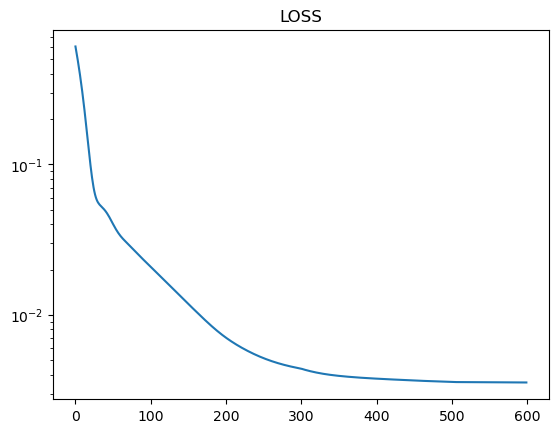

c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


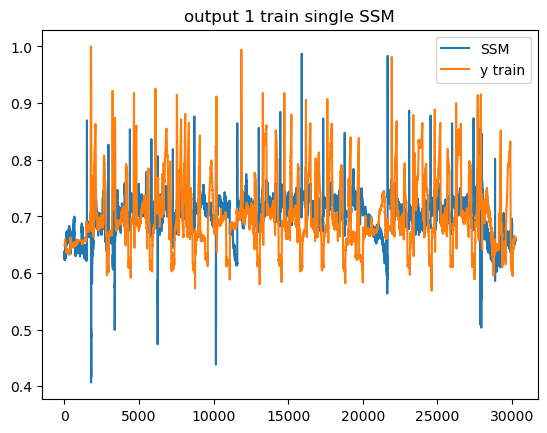

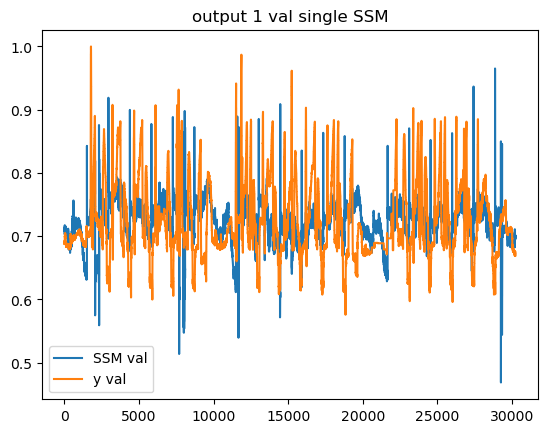

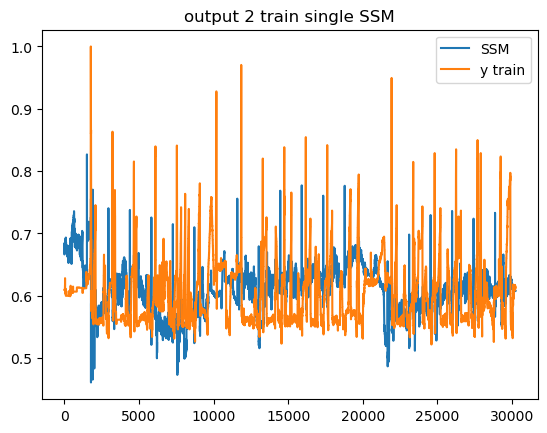

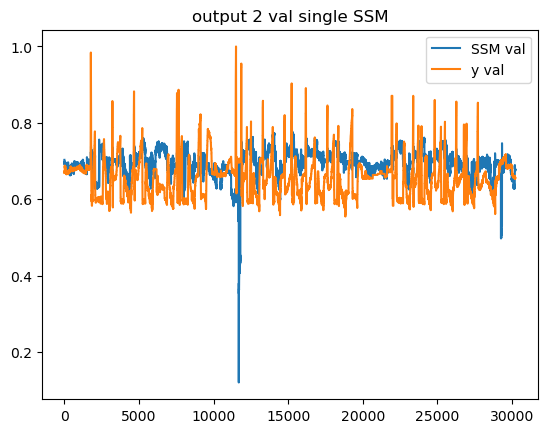

Loss Validation single SSM with one layer and separated inputs: 0.004835484083741903


In [8]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(y_pred[0, 10:, 0].detach().numpy(), label='SSM')
plt.plot(y[0, 10:, 0].detach().numpy(), label='y train')
plt.title("output 1 train single SSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(ySSM_val[0, 10:, 0].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.title("output 1 val single SSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(y_pred[0, 10:, 1].detach().numpy(), label='SSM')
plt.plot(y[0, 10:, 1].detach().numpy(), label='y train')
plt.title("output 2 train single SSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(ySSM_val[0, 10:, 1].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 1].detach().numpy(), label='y val')
plt.title("output 2 val single SSM")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single SSM with one layer and separated inputs: {loss_val}")